# Boosted Trees

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 03/01/2025   | Martin | Create   | Created notebook. Install ydf, TF latest repo for decision trees | 
| 06/01/2025   | Martin | Update   | Completed random forest, gradient boosted models. Completed boosted trees chapter | 

# Content

* [Introduction](#introduction)
* [Random Forest and Boosted Models](#random-forest-and-boosted-models)
* [Model Evaluation](#model-evaluation)

# Introduction

__Boosting/ Boosted Trees__ - Class of ML algorithms that produce a prediction model in the form on an ensemble of weak prediction models, usually decision trees.

Key benefits:
* Constructed in stage-wise dashion and generalised by arbitrary loss function
* Parallisable architecture
* Natively handles missing values and outliers
* Minimal data processing
* Relatively interpretable

In [29]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["GRPC_VERBOSITY"] = "ERROR"
os.environ["GLOG_minloglevel"] = "2"

In [3]:
import ydf
ydf.verbose(2)

1

In [5]:
# Load data
xtrain = pd.read_csv("/tmp/tensorflow-cookbook/hotel_bookings.csv")
xtrain.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [6]:
xvalid = xtrain.loc[xtrain['reservation_status_date'] >= '2017-08-01']
xtrain = xtrain.loc[xtrain['reservation_status_date'] < '2017-08-01']

ytrain, yvalid = xtrain['is_canceled'], xvalid['is_canceled']
# xtrain.drop('is_canceled', axis=1, inplace=True)
# xvalid.drop('is_canceled', axis=1, inplace=True)

_Leakage_: Refers to features that might improve performance of the model during training, but will fail when used with unseen data

Variables can be removed through expert opinion or automated through statistical analysis or using a small model to determine global feature importance.

⚠️ __If a result of global feature importance indicates a feature dominating over others, it is a potential source of leakage__

In [7]:
# Column selection
## Remove columns that might be useful but cause a risk of leakage
dropped_cols = ['arrival_date_year','assigned_room_type', 'booking_changes', 'reservation_status',
             'country', 'days_in_waiting_list']

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [8]:
xtrain_rm = xtrain.drop(dropped_cols, axis=1)
xvalid_rm = xvalid.drop(dropped_cols, axis=1)

---

# Random Forest and Boosted Models

Create a baseline ensemble model using bagging method - Random Forest Learner

In [10]:
# Random Forest Learner
rf_model = ydf.RandomForestLearner(
  label='is_canceled',
  task=ydf.Task.CLASSIFICATION
).train(xtrain_rm)

Train model on 115580 examples
Model trained in 0:00:41.935904


In [13]:
evaluation = rf_model.evaluate(xvalid_rm)

In [14]:
evaluation

Label \ Pred,0,1
0,2609,182
1,881,138


In [13]:
rf_model.describe()

In [15]:
rf_model.analyze(xtrain_rm)

Now testing with Gradient Boosted Trees

In [19]:
gb_model.describe()

In [17]:
## oob gradient boosted tree
gb_model = ydf.GradientBoostedTreesLearner(
  label='is_canceled',
  task=ydf.Task.CLASSIFICATION
).train(
  xtrain_rm,
  verbose=2
)

Train model on 115580 examples
Model trained in 0:02:07.929465


In [23]:
gb_model.evaluate(xvalid_rm)

Label \ Pred,0,1
0,298,0
1,3192,320


In [56]:
# Better default
templates = ydf.GradientBoostedTreesLearner.hyperparameter_templates()
better_defaultv1 = templates['benchmark_rank1v1']
print(better_defaultv1.description)

learner = ydf.GradientBoostedTreesLearner(
  label='is_canceled',
  **better_defaultv1
).train(
  xtrain_rm,
  verbose=2
)

Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.
Train model on 115580 examples
Model trained in 0:02:13.170103


In [57]:
learner.evaluate(xvalid_rm)

Label \ Pred,0,1
0,327,1
1,3163,319


In [61]:
config = {
 'num_trees': 125,
 'max_depth': 5,
 'l1_regularization': 0.00001,
 'l2_regularization': 0.00001,
}

gb_model_tuned = ydf.GradientBoostedTreesLearner(
  label='is_canceled',
  **config
).train(
  xtrain_rm,
  verbose=2
)

Train model on 115580 examples
Model trained in 0:00:37.645385


In [63]:
gb_model_tuned.evaluate(xvalid_rm)

Label \ Pred,0,1
0,983,54
1,2507,266


## Performance Review

Final validation accuracy of 72.1% in Random Forest model seems so outperform the Gradient Boosted model (but I suspect there is something wrong with the way the Gradient Boosted model is configured). 

Refer to the confusion matrix for deeper breakdown.

---

# Model Evaluation

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')

from numpy.random import uniform, seed
from scipy.interpolate import griddata

from matplotlib.font_manager import FontProperties
from sklearn.metrics import roc_curve

In [66]:
# Boilerplate code for plotting
def _get_color(value):
    """To make positive DFCs plot green, negative DFCs plot red."""
    green, red = sns.color_palette()[2:4]
    if value >= 0: return green
    return red

def _add_feature_values(feature_values, ax):
    """Display feature's values on left of plot."""
    x_coord = ax.get_xlim()[0]
    OFFSET = 0.15
    for y_coord, (feat_name, feat_val) in enumerate(feature_values.items()):
        t = plt.text(x_coord, y_coord - OFFSET, '{}'.format(feat_val), size=12)
        t.set_bbox(dict(facecolor='white', alpha=0.5))
    from matplotlib.font_manager import FontProperties
    font = FontProperties()
    font.set_weight('bold')
    t = plt.text(x_coord, y_coord + 1 - OFFSET, 'feature\nvalue',
    fontproperties=font, size=12)

def plot_example(example):
  TOP_N = 8 # View top 8 features.
  sorted_ix = example.abs().sort_values()[-TOP_N:].index  # Sort by magnitude.
  example = example[sorted_ix]
  colors = example.map(_get_color).tolist()
  ax = example.to_frame().plot(kind='barh',
                          color=[colors],
                          legend=None,
                          alpha=0.75,
                          figsize=(10,6))
  ax.grid(False, axis='y')
  ax.set_yticklabels(ax.get_yticklabels(), size=14)

  # Add feature values.
  _add_feature_values(xvalid.iloc[ID][sorted_ix], ax)
  return ax

## ROC Curve

A graph showing th performance of a clssifcation model at all possible classificaation thresholds. THe closer and faster the curve goes to the top left corner, the better the model performed.

In [74]:
# Get probability predictions for each entry
probs = rf_model.predict(xvalid_rm)

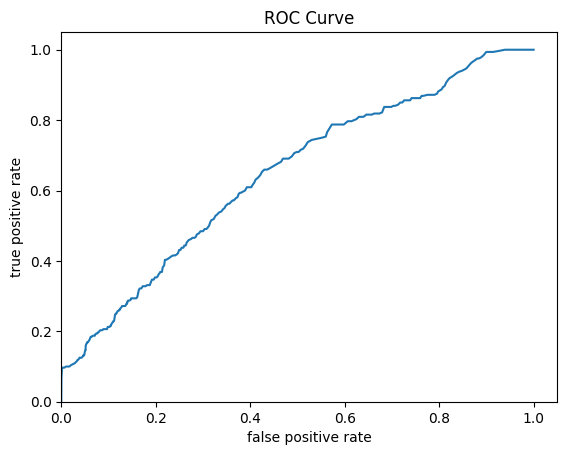

In [75]:
fpr, tpr, _ = roc_curve(yvalid, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,); plt.ylim(0,); plt.show()

## Model Interpretability

_Local interpretability_ - understand a model's predictions at an individual level - create and visualise per-instance contributions.

_Global interpretability_ - understanding the model as a whole and how features contribute to the creation of the model

* _gain-based feature importances_ - measure the loss change when splitting on a particular feature.
* ✅ _permutation-based feature importance_ - evaluating the model performance on the evaluation set by shuffling each feature one by one and attributing the change in model performance to the shuffled feature.

⚠️ __Can be unreliable in situations where potential predictor variables vary in their scale of measurement or their number of categories and when features are correlated__

Refer to pg 222-228 for plots (this version of API does not support estimators)